In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import emukit
import GPy
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from emukit.core.acquisition import IntegratedHyperParameterAcquisition



In [2]:
import pandas as pd
import numpy as np
import os


# Fe  Co  others  Ni Ti  Co_plus


folder_path = r'C:\Users\13282\Desktop\papercode\data\Aryl\original_processed' 
file_path = os.path.join(folder_path, 'aryl-1.xlsx')  # y 记得加负号 

df = pd.read_excel(file_path)

#去除存在nan的点
# nan_indices = np.isnan(Y)
# X = X[~nan_indices.flatten()]
# Y = Y[~nan_indices.flatten()]
print(df.shape)

X_all = df.iloc[:, :-1].values  
Y_all = df.iloc[:, -1].values   

print(X_all.shape,Y_all.shape)

(88, 10)
(88, 9) (88,)


# 数据预处理和建模

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


min_max_scaler = MinMaxScaler()

x_all_normalized = min_max_scaler.fit_transform(X_all)

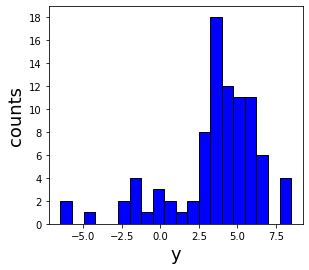

In [9]:
import seaborn as sns
# 创建一个2x1的子图
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 绘制原始y的分布直方图
axes[0].hist(Y_all, bins=20, color='blue', edgecolor='black')

axes[0].set_xlabel('y', fontsize=18)  # 设置x轴标签的字体大小为16
axes[0].set_ylabel('counts', fontsize=18)   # 设置y轴标签的字体大小为16
axes[0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
# 隐藏后两个子图
for ax in axes[1:]:
    ax.axis('off')  # 关闭坐标轴
    ax.set_visible(False)  # 设置子图为不可见

In [10]:
X = x_all_normalized
Y = Y_all.reshape(-1, 1)

In [11]:
import time

# 记录开始时间
start_time = time.time()
# 初始化模型




input_dim = len(X[0])

ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)#

model_var = 0.1
ker.lengthscale.constrain_bounded(0.001, 5) #lengthscale决定着点与点之间的相互作用程度
ker.variance.constrain_bounded(1e-2, 1e4) #方差


# model_var = 0.1
# ker.lengthscale.constrain_bounded(0.001, 20) #lengthscale决定着点与点之间的相互作用程度
# ker.variance.constrain_bounded(1e-2, 1e4) #方差


model_gpy = GPRegression(X,Y, ker)

model_gpy.Gaussian_noise.variance = model_var**2
model_gpy.Gaussian_noise.variance.fix()

model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)

base_model_1 = GPyModelWrapper(model_gpy)


# 记录结束时间
end_time = time.time()
execution_time = end_time - start_time
# 计算代码的运行时间
minutes = execution_time // 60
seconds = execution_time % 60
print(f"代码执行时间: {minutes} 分钟 {seconds} 秒")


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


代码执行时间: 0.0 分钟 6.858362197875977 秒


Train Set Metrics:
MAE: 0.04   RMSE: 0.06   spearman: 0.999   R² score: 1.0


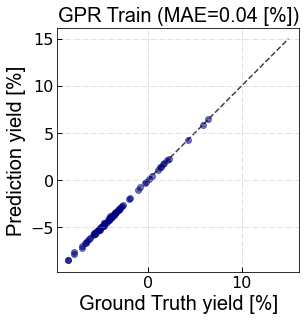

In [39]:
f_obj =  base_model_1.model.predict
y_pred, y_uncer = f_obj(X)
y_pred = -y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])
y_truth = -Y[:,-1]

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr
fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
fs = 20
lims1 = (0, 15)
axes[0].scatter(y_truth, y_pred, alpha = 0.5, c = 'navy' , edgecolor = 'navy')
axes[0].errorbar(y_truth, y_pred, yerr = y_uncer, ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)
axes[0].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)

rmse_value = np.sqrt(mean_squared_error(y_truth, y_pred))
mae_value = mean_absolute_error(y_truth, y_pred)
spearman_value = spearmanr(y_truth, y_pred)[0]
rsquared_value = r2_score(y_truth, y_pred)

print('Train Set Metrics:')
print('MAE:',np.round(mae_value,2), ' ',
      'RMSE:', np.round(rmse_value,2), ' ',
      'spearman:', np.round(spearman_value,3), ' ',
      'R² score:', np.round(rsquared_value,3))

title = 'GPR Train' + " (MAE=%.2f" % mae_value+' [%])'
axes[0].set_xlabel('Ground Truth yield [%]', fontproperties='Arial',fontsize = fs)
axes[0].set_ylabel('Prediction yield [%]',fontproperties='Arial', fontsize = fs)
axes[0].set_title(title, fontsize = fs,fontproperties='Arial')
        
for i in range(len(axes)):
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)

# 隐藏后两个子图
for ax in axes[1:]:
    ax.axis('off')  # 关闭坐标轴
    ax.set_visible(False)  # 设置子图为不可见

plt.show()


# LHS生成虚拟数据

In [43]:
def create_latin_design(X_all):
 
    x_array = [X_all[:, i] for i in range(X_all.shape[1])]
    
    num_columns = X_all.shape[1]
    parameter_space = ParameterSpace([ContinuousParameter(f'x{i+1}', 0, 1) for i in range(num_columns)])
#     design = LatinDesign(parameter_space)
    design = RandomDesign(parameter_space)
    
    
    return x_array , design

In [44]:
lhs_sample = 880

var_array , design = create_latin_design(X_all)
x_virtual = design.get_samples(lhs_sample) 

#     random_indices = np.random.choice(X_all.shape[0], 1 , replace=False)  
#     X = X_all[random_indices] 

x_virtual.shape

(8800, 9)

In [45]:
f_obj =  base_model_1.model.predict
y_pred, y_uncer = f_obj(x_virtual)
# scaler.transform(X_all_grid)
y_virtual = y_pred[:,-1]



In [46]:
print(np.min(y_virtual),np.max(y_virtual))
print(np.min(Y_all),np.max(Y_all))

-0.7243108131796029 3.0750691619085018
-6.456679595927655 8.470101583882409


# 第二种生成数据方法

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import emukit
import GPy
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from emukit.core.acquisition import IntegratedHyperParameterAcquisition


In [3]:
def find_y_by_x(x_input, X_all, Y_all):  #一通过x找到对应的y的函数
    # 确保 x_input 是一个二维数组
    if len(x_input.shape) == 1:
        x_input = x_input.reshape(1, -1)

    # 初始化一个列表来存储所有结果
    all_results = []

    # 遍历 x_input 中的每个特征向量
    for x in x_input:
        # 使用 NumPy 的函数 argwhere 来查找 x 在 X 中的位置
        indices = np.argwhere(np.all(X_all == x, axis=1))

        # 初始化一个列表来存储匹配的 Y 值
        matching_y_values = []

        # 遍历匹配的位置
        for index in indices:
            match_index = index[0]
            matching_y_values.append(Y_all[match_index])

        all_results.append(matching_y_values)
    
    all_results = np.array(all_results)
    return all_results


# 数据导入并预处理


In [4]:
import pandas as pd
import numpy as np
import os


# Fe  Co  others  Ni Ti  Co_plus

folder_path = r'C:\Users\13282\Desktop\papercode\data\Aryl\original_processed' 
file_path = os.path.join(folder_path, 'aryl-1.xlsx')  # y 记得加负号 

df = pd.read_excel(file_path)

#去除存在nan的点
# nan_indices = np.isnan(Y)
# X = X[~nan_indices.flatten()]
# Y = Y[~nan_indices.flatten()]
print(df.shape)

X_all = df.iloc[:, :-1].values  
Y_all = df.iloc[:, -1].values   
Y_all = Y_all.reshape(-1, 1)
print(X_all.shape,Y_all.shape)

(264, 9)
(264, 8) (264, 1)



# 建立虚拟数据X网格

In [6]:
import numpy as np

# 定义参数范围和步长
dim_min, dim_max, dim_step = [0, 1, 0.3] #每个维度5个点

dim_num = 8

x_labels = ['Dim1', 'Dim2', 'Dim3', 'Dim4', 'Dim5', 'Dim6', 'Dim7', 'Dim8',]
# x_labels = ['Dim1', 'Dim2', 'Dim3', 'Dim4', 'Dim5', 'Dim6', 'Dim7', 'Dim8', 'Dim9']

# 生成参数变量
dim_vars = [np.arange(dim_min, dim_max+dim_step*0.1, dim_step) for _ in range(dim_num)]

# 计算参数数量
dim_nums = [len(dim_vars[i]) for i in range(dim_num)]

# 构建参数组合的网格
var_arrays = np.meshgrid(*dim_vars, indexing='ij')
X_all_grid = np.column_stack([var_arrays[i].ravel() for i in range(dim_num)])

num_sample = 1000

random_indices = np.random.choice(X_all_grid.shape[0], num_sample , replace=False)  
X_all_grid = X_all_grid[random_indices] 

print(X_all_grid.shape)


(1000, 8)


# 用梯度回归模型来寻找最优超参数

# 上述参数模型对训练数据的二八划分拟合

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

X = X_all
y = Y_all


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

# scaler = MinMaxScaler()
# scaler.fit(X)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
# X = scaler.transform(X)

# scaler_y = StandardScaler()
# scaler_y.fit(y)
# y_train = scaler_y.transform(y_train)
# y_test = scaler_y.transform(y_test)
# y = scaler_y.transform(y)

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(10,200,10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(2,20,2)]
# Number of features to consider at every split



# max_features = ['sqrt']


# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# learning_rate 
learning_rate = np.arange(0.025,0.150,0.025)
# subsample 
subsample = np.arange(0.60, 0.95, 0.05) 
# 'reg_alpha':        
alpha = [1e-4, 1e-2, 0.1, 0.5, 0.99]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth, 
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample,
               'alpha': alpha}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, 
                               n_iter = 1000, cv = 5, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
gb_random.fit(X_train, y_train.ravel())
best_params = gb_random.best_params_



In [9]:
print(best_params)

{'subsample': 0.65, 'n_estimators': 190, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 4, 'learning_rate': 0.1, 'alpha': 0.1}


In [10]:
from sklearn.ensemble import GradientBoostingRegressor
GBregressor_list = []
y_pred_list = []
y_train_pred_list = []
y_test_pred_list = []
for i in np.arange(100):
    GBregressor = GradientBoostingRegressor()
    GBregressor.set_params(**best_params)
    #GBregressor.fit(X_train, y_train.ravel())
    GBregressor.fit(X, y.ravel())                     #对所有点进行建模训练

    GBregressor_list.append(GBregressor)
    
#     y_train_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X_train).reshape(-1,1))
#     y_test_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X_test).reshape(-1,1))
#     y_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X).reshape(-1,1))
    
    y_train_pred=GBregressor_list[i].predict(X_train).reshape(-1,1)
    y_test_pred=GBregressor_list[i].predict(X_test).reshape(-1,1)
    y_pred=GBregressor_list[i].predict(X).reshape(-1,1)
    
    y_train_pred_list.append(y_train_pred)
    y_test_pred_list.append(y_test_pred)
    y_pred_list.append(y_pred)
y_pred_mean = np.mean(y_pred_list, axis = 0)
y_train_pred_mean = np.mean(y_train_pred_list, axis = 0)
y_test_pred_mean = np.mean(y_test_pred_list, axis = 0)


train rmse: 1.9334
test rmse: 2.0017
all rmse: 1.9473
train R^2: 0.9603
test R^2: 0.9680
all R^2: 0.9626
train spearman: 0.9745
test spearman: 0.9768
all spearman: 0.9751


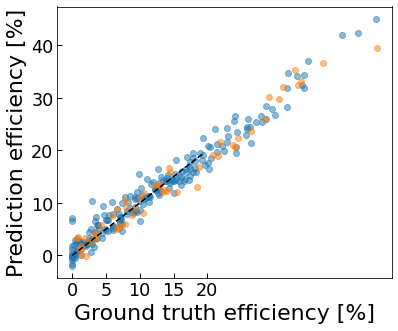

In [11]:
y_train_pred = y_train_pred_mean
y_test_pred = y_test_pred_mean
y_pred = y_pred_mean

from sklearn.metrics import mean_squared_error
mse = mean_squared_error

mse_train = mse(y_train_pred,y_train)
mse_test = mse(y_test_pred,y_test)
mse_all = mse(y_pred,y)

print ('train rmse: %.4f' % (np.sqrt(mse_train)))
print ('test rmse: %.4f' % (np.sqrt(mse_test)))
print ('all rmse: %.4f' % (np.sqrt(mse_all)))


rsquared_train = r2_score(y_train,y_train_pred)
rsquared_test = r2_score(y_test, y_test_pred)
rsquared_all = r2_score(y, y_pred)
print ('train R^2: %.4f' % (rsquared_train))
print ('test R^2: %.4f' % (rsquared_test))
print ('all R^2: %.4f' % (rsquared_all))

sprman_train = spearmanr(y_train_pred,y_train)
sprman_test = spearmanr(y_test_pred,y_test)
sprman_all = spearmanr(y_pred,y)
print ('train spearman: %.4f' % (sprman_train[0]))
print ('test spearman: %.4f' % (sprman_test[0]))
print ('all spearman: %.4f' % (sprman_all[0]))

fs = 22
plt.figure(figsize=(6, 5))
plt.scatter(y_train,y_train_pred, alpha =0.5)
plt.scatter(y_test,y_test_pred, alpha =0.5)
#plt.scatter(y_scaled,y_pred, alpha =0.5)
yref = np.arange(0, 20, 0.5)
plt.plot(yref, yref, '--',color='black')
plt.xlabel('Ground truth efficiency [%]', fontsize = fs)
plt.ylabel('Prediction efficiency [%]', fontsize = fs)
plt.xticks([0, 5, 10, 15, 20])
#plt.title("Gradient Boosting")
plt.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
#plt.savefig("Pervoskite Opt for Scale-up/Prelim_data_analysis/data_plots/RFR"+str(X1.name[:4])+".png",dpi=300)
plt.show()

# 模型对对格点进行预测

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(X_all_grid)
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)

print(np.min(y_hat_mean))
print(np.max(y_hat_mean))

0.25965164932395013
32.28118251614361


max:  32.28118251614361
min:  0.25965164932395013
top 5 perc:  24.453587409874856
top 1 perc:  29.6876599090831
top 0.1 perc:  31.271754460564043
mean:  12.717995175352394


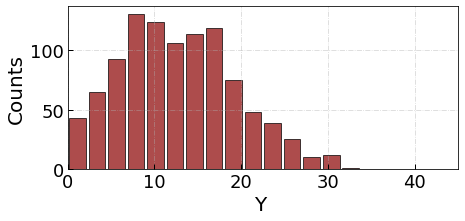

In [16]:
df_random = np.column_stack((np.arange(1, len(X_all_grid) + 1), X_all_grid, y_hat_mean))
columns_with_id = ['ID'] + x_labels + ['Sampled_Y']
df_random = pd.DataFrame(df_random, columns=columns_with_id)

print('max: ', np.max(df_random.iloc[:,-1].values))
print('min: ', np.min(df_random.iloc[:,-1].values))
print('top 5 perc: ', np.quantile(df_random.iloc[:,-1].values, 0.95))
print('top 1 perc: ', np.quantile(df_random.iloc[:,-1].values, 0.99))
print('top 0.1 perc: ', np.quantile(df_random.iloc[:,-1].values, 0.999))

print('mean: ', np.mean(df_random.iloc[:,-1].values))


fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
hist_data = axes.hist(df_random.iloc[:,-1], bins= 20, range = (0, 45), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####

# axes.text(1, 6800*2, 'Random sampling', fontsize=fs*0.9)
# axes.text(1, 6000*2, 'total conds = '+str(len(df_random)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 45)
# axes.set_ylim(0, 2000*10)
##axes.set_yticks([0, 4, 8, 12])
# axes.plot(np.ones(10)*15, np.linspace(0, 20, 10), '--')
# axes.plot(np.ones(10)*17, np.linspace(0, 20, 10), '--', color = 'black')
axes.set_xlabel('Y ', fontsize = fs)

plt.show()

In [17]:
y_hat_mean = y_hat_mean .reshape(-1, 1)

In [18]:

print( X_all_grid.shape ,y_hat_mean.shape)
print( X_all.shape ,Y_all.shape)

(1000, 8) (1000, 1)
(264, 8) (264, 1)


# 保存文件

In [20]:
columns = [f'x{i+1}' for i in range(X_all_grid.shape[1])]
df_x = pd.DataFrame(X_all_grid, columns=columns)
df_y = pd.DataFrame(y_hat_mean, columns=['y_log'])

final_data = pd.concat([df_x, df_y], axis=1)
final_data = final_data.reset_index(drop=True)
final_data.to_excel('Virtual_1.xlsx', index=False)

# 数据合并

In [19]:
# 合并 X_all_grid 和 X_all
merged_x = np.concatenate((X_all_grid, X_all), axis=0)
# 合并 y_hat_mean 和 Y_all
merged_y = np.concatenate((y_hat_mean, Y_all), axis=0)

print( merged_x.shape ,merged_y.shape)

(880, 9) (880, 1)


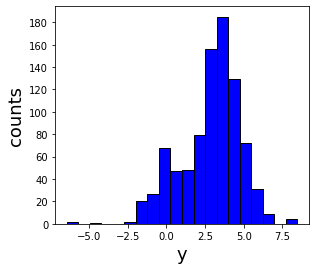

In [20]:
import seaborn as sns
# 创建一个2x1的子图
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 绘制原始y的分布直方图
axes[0].hist(merged_y, bins=20, color='blue', edgecolor='black')

axes[0].set_xlabel('y', fontsize=18)  # 设置x轴标签的字体大小为16
axes[0].set_ylabel('counts', fontsize=18)   # 设置y轴标签的字体大小为16
axes[0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
# 隐藏后两个子图
for ax in axes[1:]:
    ax.axis('off')  # 关闭坐标轴
    ax.set_visible(False)  # 设置子图为不可见

In [21]:
print(np.min(merged_y))
print(np.max(merged_y))

-6.456679595927655
8.470101583882409


In [23]:
columns = [f'x{i+1}' for i in range(merged_x.shape[1])]
df_x = pd.DataFrame(merged_x, columns=columns)
df_y = pd.DataFrame(merged_y, columns=['y_log'])

final_data = pd.concat([df_x, df_y], axis=1)
final_data = final_data.reset_index(drop=True)
final_data.to_excel('Virtual_original.xlsx', index=False)

# 导入虚拟数据集合

In [83]:
# 导入 pandas 包
import pandas as pd

# 文件的路径
csv_file_path = 'data/Virtual_data1.csv'

# 读取 CSV 文件
df = pd.read_csv(csv_file_path)

# 显示 DataFrame 的前几行以确认数据已经被正确读入
print(df.head())

    ID  Dim1  Dim2  Dim3  Dim4  Dim5  Dim6  Dim7  Sampled_Y
0  1.0   0.0   0.0   0.0   0.0   0.0   0.0  0.00   3.516221
1  2.0   0.0   0.0   0.0   0.0   0.0   0.0  0.25   4.002606
2  3.0   0.0   0.0   0.0   0.0   0.0   0.0  0.50   3.909949
3  4.0   0.0   0.0   0.0   0.0   0.0   0.0  0.75   3.898546
4  5.0   0.0   0.0   0.0   0.0   0.0   0.0  1.00   3.898546


In [84]:
# 随机抽取1000个点
df_sample = df.sample(n=1000, random_state=1)

# 显示抽取的点
print(df_sample.head())





            ID  Dim1  Dim2  Dim3  Dim4  Dim5  Dim6  Dim7  Sampled_Y
42169  42170.0  0.50  0.75  0.50  0.50  0.25  0.75  1.00   3.936326
13983  13984.0  0.00  1.00  0.50  0.25  1.00  0.25  0.75   0.447191
48423  48424.0  0.75  0.00  0.50  0.50  0.25  1.00  0.75   4.985354
76891  76892.0  1.00  1.00  0.75  0.00  0.00  0.75  0.25  -1.116554
9137    9138.0  0.00  0.50  1.00  0.75  0.00  0.50  0.50   3.984546


(1000,)


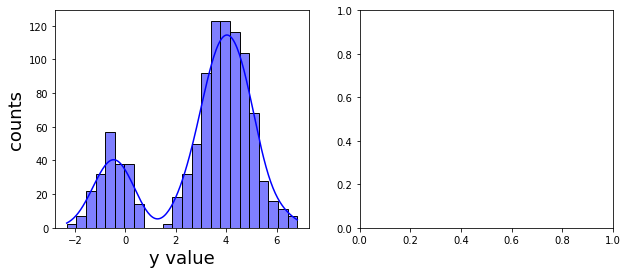

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
# 创建一个2x1的子图
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 绘制原始y的分布直方图
sns.histplot(df_sample.iloc[:, -1].values, kde=True, color='blue', ax=axes[0])
axes[0].set_xlabel('y value', fontsize=18)  # 设置x轴标签的字体大小为16
axes[0].set_ylabel('counts', fontsize=18)   # 设置y轴标签的字体大小为16

print(df_sample.iloc[:, -1].shape)

In [89]:
# 将新的数据集保存为 CSV 文件
new_csv_file_path = 'data/test_data.csv'
df_sample.to_csv(new_csv_file_path, index=False)